### They are all equally spaced

In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from matplotlib.animation import FuncAnimation
import os

In [3]:
save_path = r'C:\Users\Leopold\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Plots\Qutip'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [58]:
########################################                 Define constants                   #############################################
N = 30
fixed_lam   = 1
fixed_gamma = 1

fixed_dist  = 0.3 * fixed_lam

t_max    = 40
t_size   = 100
########################################################################################################################    
times  = np.linspace(0, t_max, t_size) * fixed_gamma

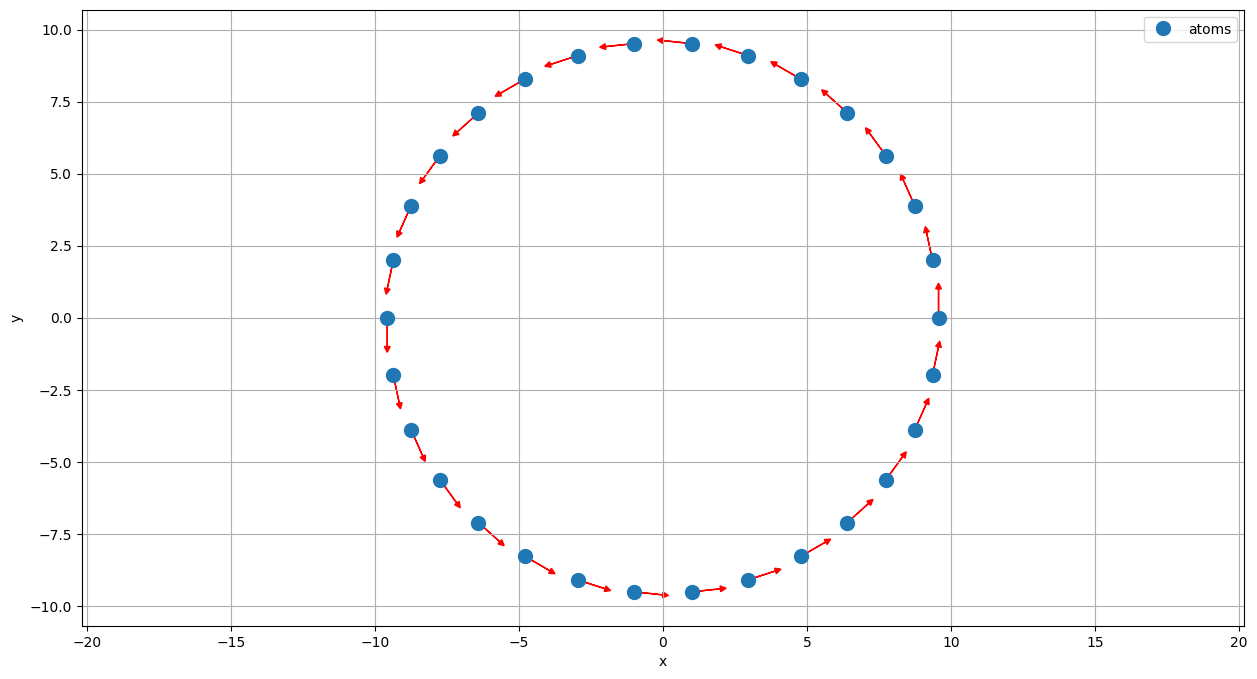

In [59]:
########################################               define the geometry                 #############################################
def dipole_vector(phi = 0):
    """Returns the dipole vector given its orientation by angle phi."""
    dipole = np.array([np.cos(phi), np.sin(phi), 0])
    return dipole

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]])

def ring_positions(distance = fixed_dist, N = N):
    Pos = np.zeros((N, 3))
    dphi = 2 * np.pi / N
    radius = distance / 2 / np.sin(np.pi / N)
    helper = np.array([radius, 0, 0])
    for i in range(N):
        rotation_matrix = np.linalg.matrix_power(z_rotation(dphi), i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos

positions = ring_positions(2)
dipoles = np.zeros_like(positions)
for i in range(N):
    dipoles[i] = dipole_vector(np.arctan2(positions[i,1], positions[i,0])+np.pi/2)
# Plot the atom positions
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(positions[:, 0], positions[:, 1], 'o', markersize=10, label='atoms')
for i, position in enumerate(positions):
    ax.arrow(position[0], position[1], dipoles[i][0], dipoles[i][1], 
             head_width=0.2, head_length=0.2, fc='r', ec='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True)
ax.legend()
ax.axis('equal')
plt.show()

In [82]:
########################################             create the Hamiltonean                 #################################################
def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    return (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                    * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                       + (- kappa ** 2 - 3 * 1j * kappa + 3)
                       * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))

def Gamma_matrix(distance, dipoles, lam, gamma):
    positions = ring_positions(distance)
    G_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            G_matrix[a, b] = gamma
            r_a, r_b = positions[a], positions[b]
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                result = (6 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
                G_matrix[a, b] = np.imag(result)
    return G_matrix

def V_matrix(distance, dipoles, lam, gamma):
    positions = ring_positions(distance, N)
    V_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a, r_b = positions[a], positions[b]
            V_matrix[a, b] = 0
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                result = (3 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
                V_matrix[a, b] = np.real(result)
    return V_matrix
    
def H_eff(distance = fixed_dist, dipoles = [dipole_vector() for _ in range(N)], lam=fixed_lam, gamma=fixed_gamma):
    G = Gamma_matrix(distance, dipoles, lam, gamma)
    V = V_matrix(distance, dipoles, lam, gamma)
    return Qobj(V) - 1j / 2 * Qobj(G)

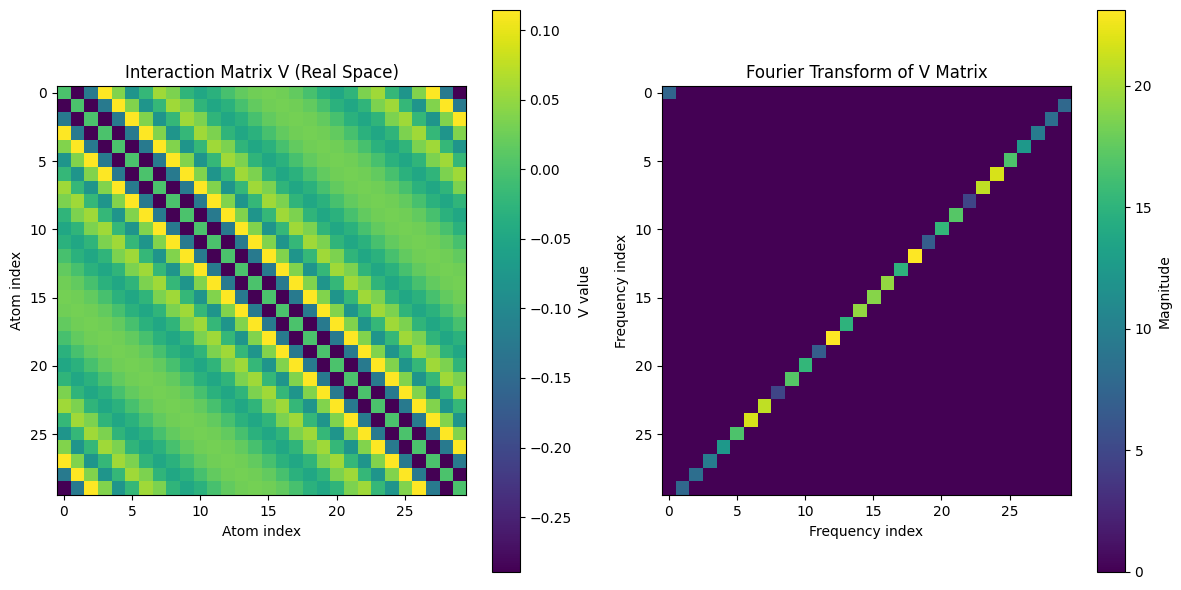

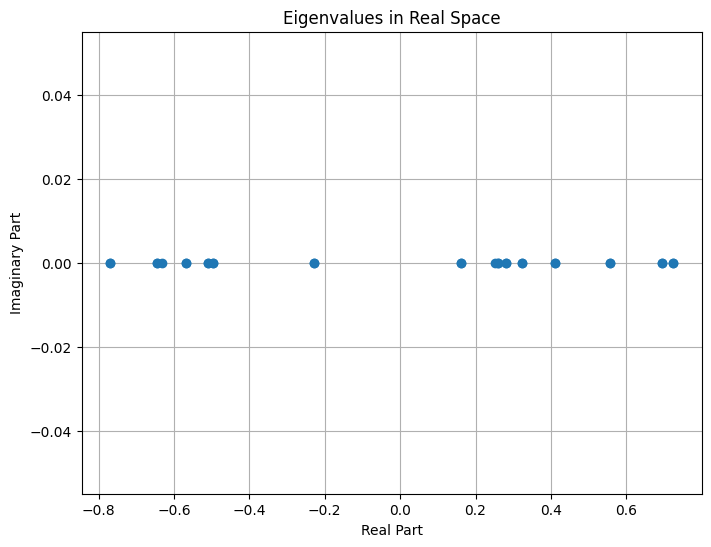

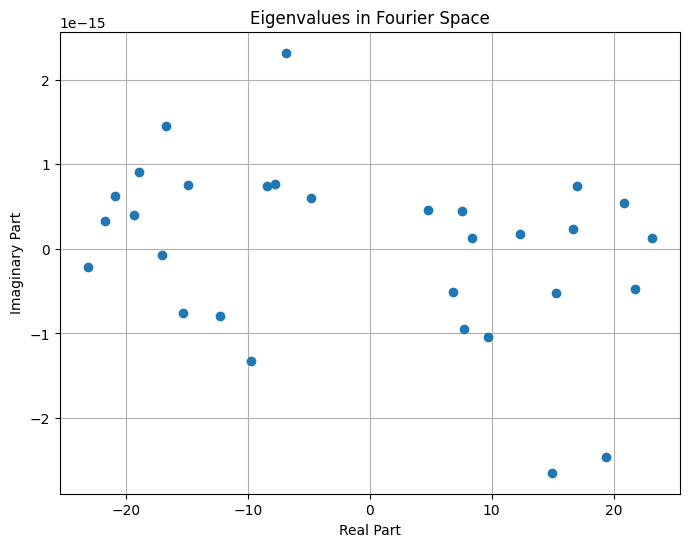

In [93]:
V = V_matrix(fixed_dist, np.array([[0, 0, 1]] * N) , fixed_lam, fixed_gamma)
V = np.real(V)
# Perform the Fourier transform
from scipy.fft import fft2, fftshift
V_fourier = fftshift(fft2(V))

from numpy.linalg import eig
# Compute the eigenvalues of the real-space matrix
eigenvalues_real, _ = eig(V)

# Perform the Fourier transform
V_fourier = fftshift(fft2(V))

# Compute the eigenvalues of the Fourier-transformed matrix
eigenvalues_fourier, _ = eig(V_fourier)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the real-space matrix V
plt.subplot(1, 2, 1)
plt.title('Interaction Matrix V (Real Space)')
plt.imshow(V, cmap='viridis', interpolation='nearest')
plt.colorbar(label='V value')
plt.xlabel('Atom index')
plt.ylabel('Atom index')

# Plot the Fourier-space matrix V
plt.subplot(1, 2, 2)
plt.title('Fourier Transform of V Matrix')
plt.imshow(np.abs(V_fourier), cmap='viridis', interpolation='nearest')
plt.colorbar(label='Magnitude')
plt.xlabel('Frequency index')
plt.ylabel('Frequency index')

plt.tight_layout()
plt.show()

# Plot the eigenvalues in real space
plt.figure(figsize=(8, 6))
plt.title('Eigenvalues in Real Space')
plt.plot(np.real(eigenvalues_real), np.imag(eigenvalues_real), 'o')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()

# Plot the eigenvalues in Fourier space
plt.figure(figsize=(8, 6))
plt.title('Eigenvalues in Fourier Space')
plt.plot(np.real(eigenvalues_fourier), np.imag(eigenvalues_fourier), 'o')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()

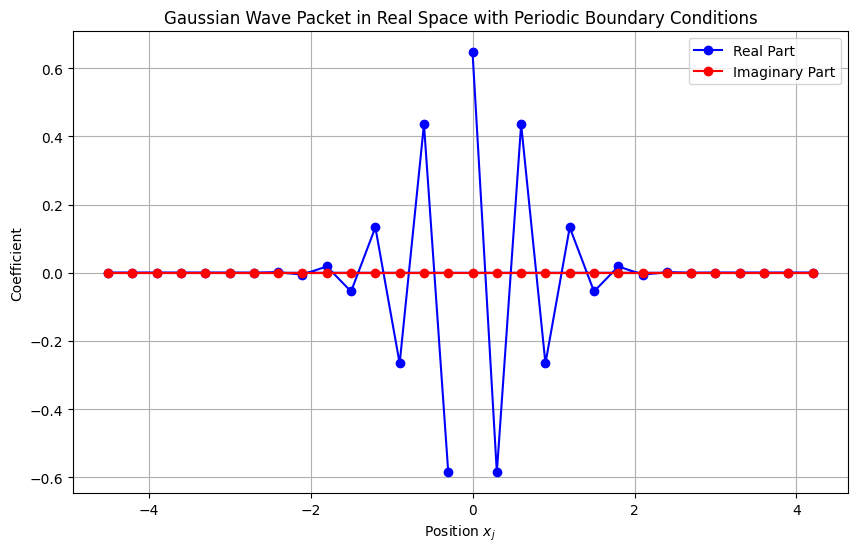

Quantum object: dims=[[30], [1]], shape=(30, 1), type='ket', dtype=Dense
Qobj data =
[[ 5.00662389e-01]
 [-4.53609164e-01]
 [ 3.37359060e-01]
 [-2.05957040e-01]
 [ 1.03213050e-01]
 [-4.24586601e-02]
 [ 1.43374417e-02]
 [-3.97420943e-03]
 [ 9.04281279e-04]
 [-1.68900150e-04]
 [ 2.58958540e-05]
 [-3.25914846e-06]
 [ 3.36706698e-07]
 [-2.85544023e-08]
 [ 1.98777899e-09]
 [-1.13589143e-10]
 [ 1.98777899e-09]
 [-2.85544023e-08]
 [ 3.36706698e-07]
 [-3.25914846e-06]
 [ 2.58958540e-05]
 [-1.68900150e-04]
 [ 9.04281279e-04]
 [-3.97420943e-03]
 [ 1.43374417e-02]
 [-4.24586601e-02]
 [ 1.03213050e-01]
 [-2.05957040e-01]
 [ 3.37359060e-01]
 [-4.53609164e-01]]


In [94]:
# Define the position indices with periodic boundary conditions
center_index = N
k_s = np.pi / fixed_dist
sigma = 0.1 * k_s
x_j = (np.arange(N) - center_index) * fixed_dist
x_j = np.mod(x_j + N//2 * fixed_dist, N * fixed_dist) - N//2 * fixed_dist
# Calculate the Gaussian wave packet in real space with periodic boundary conditions
coefficients = np.sqrt(sigma / np.sqrt(2 * np.pi)) * np.exp(-1j * k_s * x_j) * np.exp(-sigma**2 * x_j**2)
wave_packet = sum(coeff * basis(N, (j+center_index)%N) for j, coeff in enumerate(coefficients))
psi0 = wave_packet.unit()

# Plot the real and imaginary parts of the wave packet coefficients
plt.figure(figsize=(10, 6))
plt.plot(x_j, coefficients.real, 'bo-', label='Real Part')
plt.plot(x_j, coefficients.imag, 'ro-', label='Imaginary Part')
plt.xlabel('Position $x_j$')
plt.ylabel('Coefficient')
plt.title('Gaussian Wave Packet in Real Space with Periodic Boundary Conditions')
plt.legend()
plt.grid(True)
plt.show()

print(psi0)

In [113]:
from scipy.optimize import minimize
def survival_probabilities(distance, times, Psi_0=psi0): #
    positions = ring_positions(distance)
    dipoles = np.zeros_like(positions)
    for i in range(N):
        dipoles[i] = [0,0,1]#dipole_vector(np.arctan2(positions[i,1], positions[i,0])+np.pi/2) 
    H = H_eff(distance, dipoles)
    coeffs_sq_mods = np.zeros((len(times), N))
    P_surs = np.zeros(len(times))
    
    for t_idx, t in enumerate(times):
        U = (-1j * H * t).expm()
        Psi_t = (U * Psi_0).full().flatten()
        Probs = np.abs(Psi_t)**2
        coeffs_sq_mods[t_idx, :] = Probs
        P_surs[t_idx] = Probs.sum()
    return coeffs_sq_mods, P_surs

# Define an optimization function that returns the negative of survival probability
def optimization_target(params):
    _, res = survival_probabilities(params[0], [times[-1]])
    return -res[0]

# Initial guess for the distance
initial_distance = 0.234 * fixed_lam

# Perform optimization
result = minimize(optimization_target, [initial_distance], method='SLSQP', options={'maxiter': 1000})

optimized_distance = result.x[0]

print("Optimized distance:")
print(optimized_distance)

Optimized distance:
0.13106627279520036


In [114]:
y1, y2 = survival_probabilities(optimized_distance, times, Psi_0=basis(N,N//2))

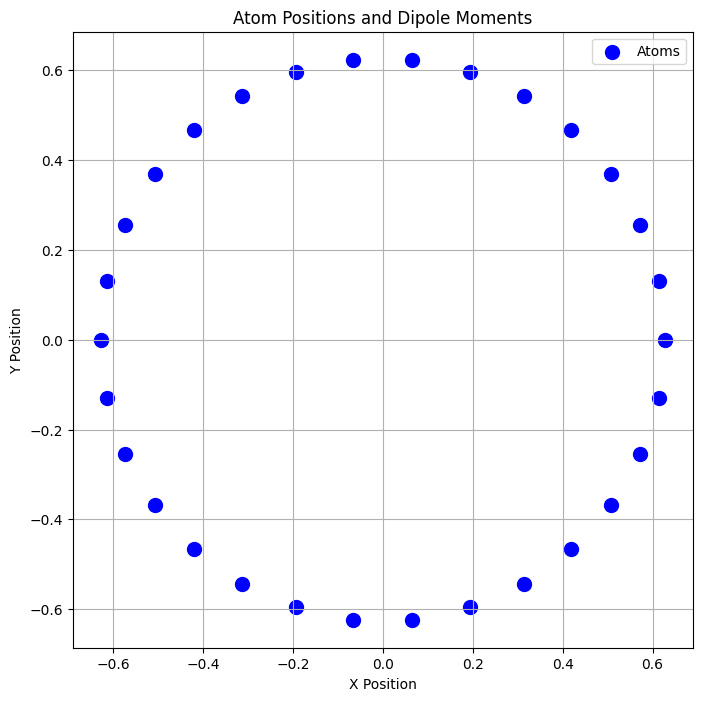

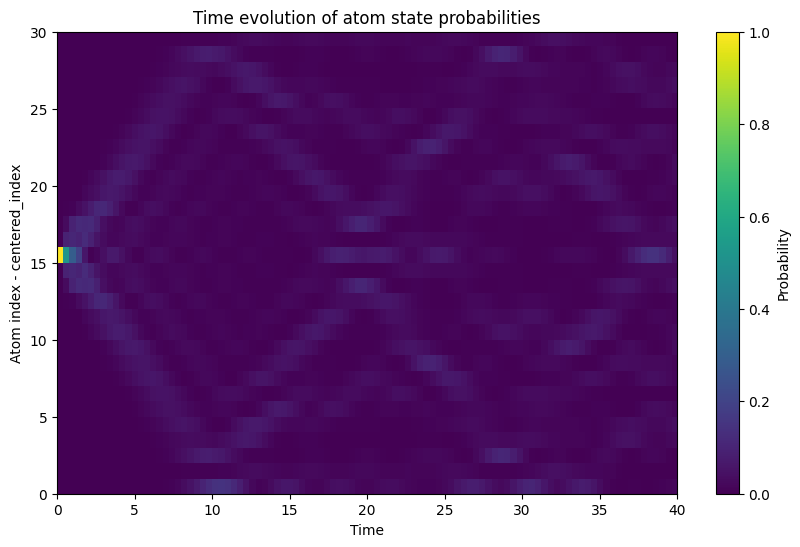

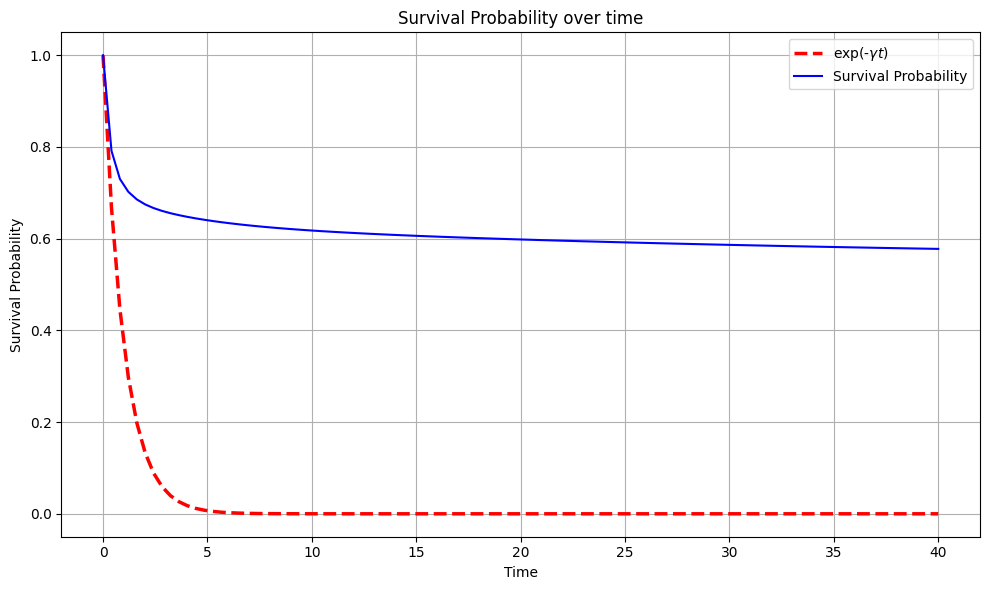

In [115]:
# Plot atoms with their dipole moments
positions = ring_positions(optimized_distance, N)
plt.figure(figsize=(8, 8))
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=100, label='Atoms')
#for i, position in enumerate(positions):
#    plt.arrow(position[0], position[1], dipoles[i][0], dipoles[i][1], head_width=0.2, head_length=0.2, fc='r', ec='r')
plt.title('Atom Positions and Dipole Moments')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()
# Create a heatmap for state probabilities
plt.figure(figsize=(10, 6))
plt.imshow(y1.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N])
plt.colorbar(label='Probability')
plt.xlabel('Time')
plt.ylabel('Atom index - centered_index')
plt.title('Time evolution of atom state probabilities')
plt.show()

# Plot survival probability
plt.figure(figsize=(10, 6))
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.plot(times, y2, 'b-', label='Survival Probability')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Probability over time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()